In [4]:
# reference: 1. https://blog.keras.io/building-autoencoders-in-keras.html
# reference: 2. https://keras.io/examples/generative/vae/

# import packages
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from keras.datasets import mnist 
from keras import backend as K
import matplotlib.pyplot as plt

# Initial Setup
original_dim = 28 * 28
intermediate_dim1 = 256
# intermediate_dim2 = 64
latent_dim = 2
beta = 1.0                  # beta is the weight for penalizer, in paper, it is lambda
tf.random.set_seed(111)

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim1, activation='relu')(inputs)
# h = layers.Dense(intermediate_dim2, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

# sample new data points from latent space (re-parameterization trick):
def sampling(args):
    z_mean, z_log_sigma = args
    # dimension of epsilon: batch_size by 2 in this example
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)                       
    return z_mean + K.exp(0.5*z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder:
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim1, activation='relu')(latent_inputs)
x = layers.Dense(intermediate_dim2, activation='relu')(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model:
outputs = decoder(encoder(inputs)[2]) # get latent vector z
vae = keras.Model(inputs, outputs, name='vae_mlp')

# specify loss function:

# 1. reconstruction_loss: assuming Bernoulli distribution for p_theta(x|z)
#    if assume Normal distribution, refer code here: 
#    https://gist.github.com/sergeyprokudin/4a50bf9b75e0559c1fcd2cae860b879e

# reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) # inputs: x, outputs: x_hat
# reconstruction_loss *= original_dim

# Another way to write Bernoulli distribution for p_theta(x|z)
reconstruction_loss = inputs*tf.math.log(1e-10+outputs) + (1-inputs)*tf.math.log(1e-10+1-outputs)
reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=1)

# # reconstruction loss: assuming Normal distribution for p_theta(x|z)
# mse = -0.5*K.sum(K.square((outputs-mu)/K.exp(logsigma)),axis=1)
# sigma_trace = -K.sum(logsigma, axis=1)
# log2pi = -0.5*n_dims*np.log(2*np.pi)

# 2. divergence loss: KL_loss
# kl_loss = 0.5*K.sum(K.square(z_mean) + K.exp(z_log_sigma) - 1 - z_log_sigma, axis = -1)
# # total loss (combine with first term)
# vae_loss = K.mean(-reconstruction_loss + beta*kl_loss)

# another way (Monte Carlo method) to calculate KL divergence (also works)
# log_diff_p_qphi = 0.5*(-K.square(z) + z_log_sigma + K.square(z-z_mean)/K.exp(z_log_sigma))
# kl_loss = -K.sum(log_diff_p_qphi, axis = 1)
# # total loss (combine with first term)
# vae_loss = K.mean(-reconstruction_loss + beta*kl_loss)

# 3. divergence loss: HD_loss: doesn't use closed form
log_diff_p_qphi = 0.5*(-K.square(z) + z_log_sigma + K.square(z-z_mean)/K.exp(z_log_sigma))
Aff_loss = K.exp(0.5*K.sum(log_diff_p_qphi, axis = 1))
# # 3. divergence loss: HD loss: closed form
# # Aff_loss = K.pow(K.prod(K.exp(z_log_sigma), axis = 1), 0.25)/K.sqrt(K.prod((K.exp(z_log_sigma)+1)/2, axis = 1))*K.exp(-0.25*K.sum(K.square(z_mean)/(K.exp(z_log_sigma)+1) ,axis = 1)) 
# Aff_loss = K.sqrt(K.prod(K.exp(0.5*z_log_sigma)/(K.exp(z_log_sigma)+1), axis = 1))*K.exp(-0.25*K.sum(K.square(z_mean)/(K.exp(z_log_sigma)+1) ,axis = 1)) 
# # HD total loss (combine with first term)
# # vae_loss = K.mean(-reconstruction_loss +4*beta*(1- Aff_loss))
vae_loss = K.mean(-reconstruction_loss + beta*(1-Aff_loss))

# 4. divergence loss: VNED loss
# log_diff_p_qphi = 0.5*(-K.square(z) + z_log_sigma + K.square(z-z_mean)/K.exp(z_log_sigma))
# VNED_loss = K.exp(-K.exp(K.sum(log_diff_p_qphi, axis=1) ))
# # VNED total loss:
# vae_loss = K.mean(-reconstruction_loss + beta*(1-VNED_loss))

vae.add_loss(vae_loss)
vae.compile(optimizer="SGD")  # choices: RMSprop, SGD, Adam
# Another way for optimization (can specify learning rate)
# opt = keras.optimizers.Adam(learning_rate=1e-4)
# vae.compile(optimizer=opt)

# Fit model
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# for the following: len(x_train) = 6000, np.prod(x_train.shape[1:]) = 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) 
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
  
vae_fit = vae.fit(x_train, y_train,
                  epochs=20,
                  batch_size=100,
                  validation_data=(x_test, y_test))

Epoch 1/20
600/600 [==============================] - 6s 10ms/step - loss: 236.8263 - val_loss: 169.7251
Epoch 2/20
600/600 [==============================] - 5s 9ms/step - loss: 168.4863 - val_loss: 161.6664
Epoch 3/20
600/600 [==============================] - 5s 9ms/step - loss: 161.3141 - val_loss: 157.6226
Epoch 4/20
600/600 [==============================] - 5s 9ms/step - loss: 157.4620 - val_loss: 155.7842
Epoch 5/20
600/600 [==============================] - 5s 9ms/step - loss: 154.6319 - val_loss: 153.8035
Epoch 6/20
600/600 [==============================] - 5s 9ms/step - loss: 152.8435 - val_loss: 152.2745
Epoch 7/20
600/600 [==============================] - 5s 9ms/step - loss: 151.4270 - val_loss: 150.4873
Epoch 8/20
600/600 [==============================] - 5s 9ms/step - loss: 150.3032 - val_loss: 150.6578
Epoch 9/20
600/600 [==============================] - 5s 9ms/step - loss: 149.7761 - val_loss: 150.3891
Epoch 10/20
600/600 [==============================] - 5s 9ms/s

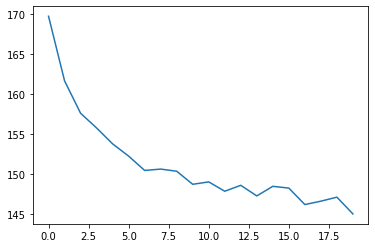

In [5]:
plt.plot(vae_fit.history['val_loss'])

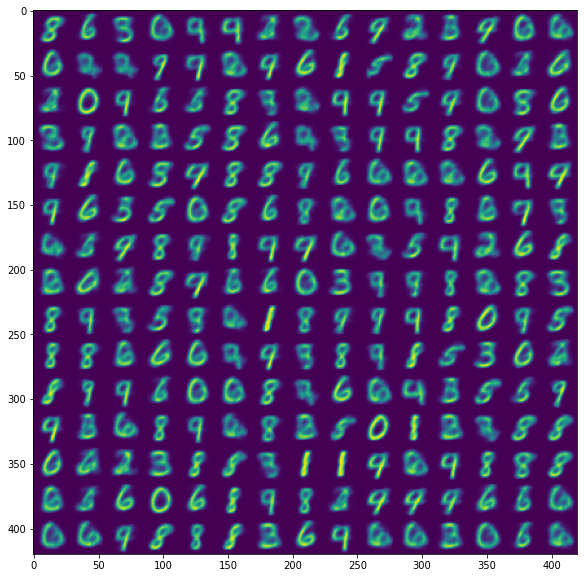

In [7]:
# Because the VAE is a generative model, we can also use it to generate new digits! 
# Here we will scan the latent plane, sampling latent points at regular intervals, 
# and generating the corresponding digit for each of these points. This gives us 
# a visualization of the latent manifold that "generates" the MNIST digits.  

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # z_sample = np.array([[xi, yi]])
        z_sample = np.random.normal(0., 3, size = [1, latent_dim]) # for random order
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

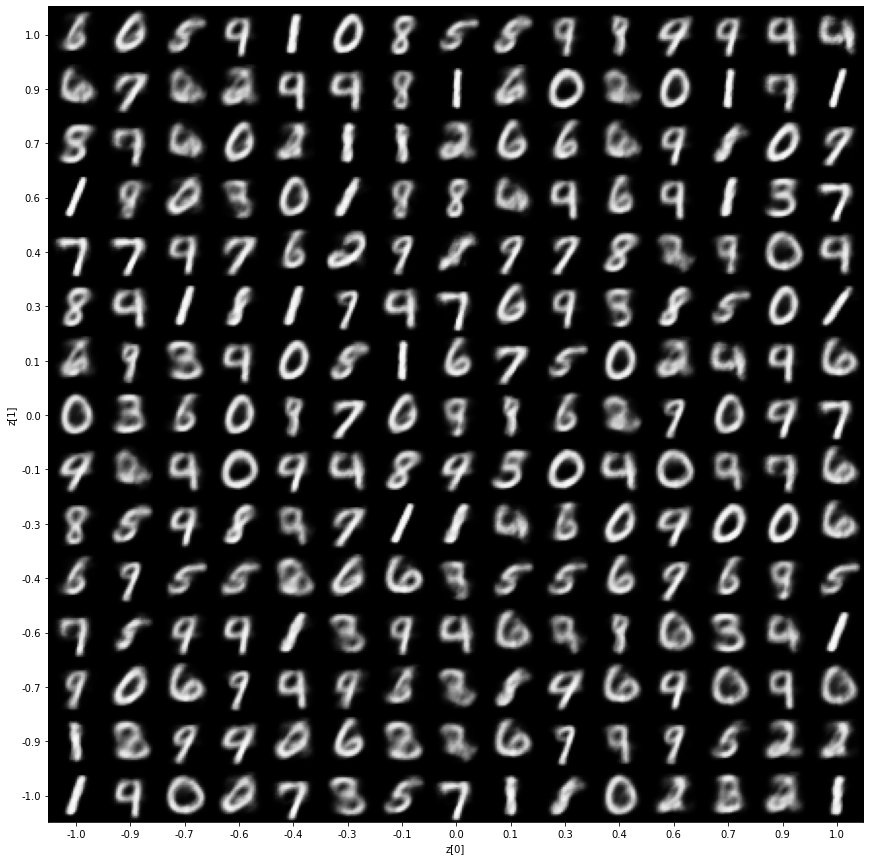

In [6]:
# Another way to create a mnist picture:
def plot_latent_space(decoder, n=15, figsize=15):
    # np.random.seed(1)  
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # z_sample = np.array([[xi, yi]])                  # for fixed order
            z_sample = np.random.normal(0., 5, size = [1, latent_dim]) # for random order
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(decoder)

In [ ]:
# Display how the latent space clusters different digit classes
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, x_train, y_train)

In [ ]:
# supplementary codes:
# mse = -0.5*K.sum(K.square((epsilon-z_mean)/K.exp(z_log_sigma)),axis=1)
# sigma_trace = -K.sum(z_log_sigma, axis=1)
# log2pi = -0.5*latent_dim*np.log(2*np.pi)